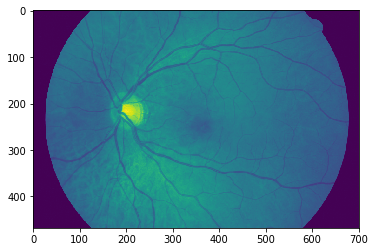

In [1]:
# Necessary imports are put here.
%matplotlib inline
from skimage import color, io, feature, filters
from utilities import *
from sklearn import metrics
import matplotlib.pyplot as plt
import cv2
import numpy as np
import skimage.morphology as mp
import functools
import operator
import pandas as pd

# Załaduj zdjęcie do pamięci
def load_img(img_num, directory):
    if img_num < 10:
        img_num = f"0{img_num}"
    if directory == 'photos':
        return change_resolution(color.rgb2gray(io.imread(f"photos/{img_num}_h.jpg")), 5)
    elif directory == 'labels':
        return change_resolution(io.imread(f"labels/{img_num}_h.tif"), 5)
    
def normalize(img):
    return img / np.max(img)

img = load_img(2, 'photos')
plt.imshow(img)

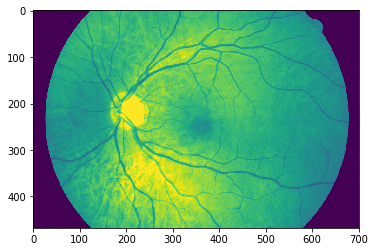

In [2]:
# Preprocessing

# Wyciągnij niezerowe wartości ze zdjęcia aby na ich podstawie obliczyć percentyle do kontrastu
# (duża ilość zer w otoczeniu może niekorzystnie wpłynąć na poszerzanie kontrastu)
def increase_contrast(img):
    nonzero_photo = img[np.nonzero(img)]
    percentiles = np.percentile(nonzero_photo,(2, 99))
    return contrast_image(img, percentiles[0], percentiles[1])

contrasted_img = increase_contrast(img)
plt.imshow(contrasted_img)

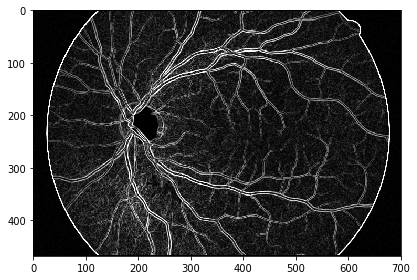

In [3]:
# Wykrywanie krawędzi
def detect_edges(img):
    img_sobel = filters.sobel(img)
    perc = np.percentile(img_sobel, (1, 99))
    return contrast_image(img_sobel, perc[0], perc[1])

img_sobel = detect_edges(contrasted_img)
io.imshow(img_sobel)

C:\Users\Ja\conda\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


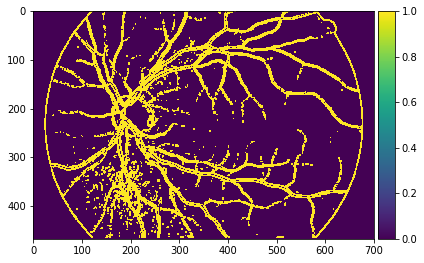

In [4]:
# Postprocessing
def apply_morphology(img):
    result = threshold(img, 0.23)
    result = mp.erosion(result, mp.square(2))
    result = mp.dilation(result, mp.square(2))
    return mp.dilation(result, mp.square(2))

result = apply_morphology(img_sobel)
io.imshow(result)

In [5]:
def flatten(arr):
    return functools.reduce(operator.iconcat, arr, [])

In [6]:
# Dzielenie obrazu na kwadraty o boku slice_size
def round_to_slice_size(dim):
    return slice_size * ((dim-slice_size) // slice_size)

def slice_image(image, step):
    slices = []

    for r in range(0, round_to_slice_size(image.shape[0]), step):
        for c in range(0, round_to_slice_size(image.shape[1]), step):
            slices.append(image[r:r+slice_size, c:c+slice_size])

    return slices

In [7]:
# Obliczenie momentów Hu próbek
def to_hu_moments(imgs):
    hu_list = []
    for img in imgs:
        moments = cv2.moments(np.vectorize(float)(img))
        hu_moments = cv2.HuMoments(moments)
        hu_list.append(flatten(hu_moments))
        
    return pd.DataFrame(hu_list)

In [8]:
def reshape_labels(labels, shape):
    return labels.reshape(round_to_slice_size(shape[0]), round_to_slice_size(shape[1]))

In [9]:
from sklearn.utils import resample
from sklearn import ensemble

slice_size = 7
def preprocess(img):
    img = normalize(img)
    img = increase_contrast(img)
    img = detect_edges(img)
    return img

def take_samples(img, step):
    slices = slice_image(img, step)
    slices = [flatten(slice) for slice in slices]
#     slices = np.append(slices, to_hu_moments(slices), axis=1)
#     slices = to_hu_moments(slices)
    return pd.DataFrame(slices)

def label_samples(img, step):
    slices = slice_image(img, step)
    central_pixels = [np.round(slice[slice_size//2][slice_size//2]) for slice in slices]
    return pd.DataFrame(central_pixels)

def prepare_data(i, slice_step):
    x_img = load_img(i, 'photos')
    y_img = load_img(i, 'labels')
    x_img = preprocess(x_img)
    y_img = normalize(y_img)
    samples = take_samples(x_img, slice_step)
    labels = label_samples(y_img, slice_step)
    return samples.assign(label = labels)

def downsample_majority(df):
    minority_count = int(np.sum(df.loc[:, 'label']))
    minority_df = df[df.label == 0]
    majority_df = df[df.label == 1]
    majority_df = resample(majority_df, replace=False, n_samples=minority_count)
    return pd.concat([minority_df, majority_df])

frames = []
for i in range(1, 6):
    df = prepare_data(i, 5)
    df = downsample_majority(df)
    frames.append(df)
training_df = pd.concat(frames)

In [10]:
from sklearn.model_selection import cross_val_score

clf = ensemble.RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(training_df.loc[:, training_df.columns != 'label'], training_df.loc[:,'label'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
scores = cross_val_score(clf, training_df.loc[:, training_df.columns != 'label'], training_df.loc[:,'label'], cv=5, verbose=20, n_jobs=4)
scores

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.7min
[Parallel(n_jobs=4)]: Done   3 out of   5 | elapsed:  1.1min remaining:   44.0s


In [ ]:
full_img_df = prepare_data(7, 1)
labels = clf.predict(full_img_df.loc[:, full_img_df.columns != 'label'])

In [ ]:
full_img_labels = normalize(load_img(7, 'labels'))
io.imshow(load_img(7, 'photos'))
io.show()
io.imshow(reshape_labels(labels, full_img_labels.shape))

In [ ]:
clipped_output_img = full_img_labels[:round_to_slice_size(full_img_labels.shape[0]), :round_to_slice_size(full_img_labels.shape[1])]
cf_mx = metrics.confusion_matrix(flatten(clipped_output_img), labels)
print("Confusion matrix:")
print(cf_mx)
print('Sensitivity: ', cf_mx[1,1]/(cf_mx[1,0] + cf_mx[1,1]))
print('Specificity: ', cf_mx[0,0]/(cf_mx[0,0] + cf_mx[0,1]))
print('Accuracy: ', (cf_mx[0,0]+cf_mx[1,1])/sum(flatten(cf_mx)))
io.imshow(full_img_labels)